# Учебный проект №6. Прогноз стоимости авто по характеристикам

Задачей проекта является построение модели предсказывающей цену автомобиля по его характеристикам. Условия задачи представлены на платформе Kaggle https://www.kaggle.com/c/sf-dst-car-price-prediction

В рамках выполнения проекта необходимо собрать данные об автомобилях из открытых источников. Обработать полученные данные и сделать прогноз на тестовой выборке (она приложена к соревнованию на Kaggle).

Проект выполнялся без команды. Ник на Kaggle - Nikolay Lukichev.

In [2]:
from bs4 import BeautifulSoup    
import requests
import pandas as pd
import numpy as np
import pandas_profiling
from pprint import pprint
import time
import json
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor

## Анализ тестового датасета

Посмотрим сначала на тестовый датасет, чтоб определиться какие признаки нам нужны.

In [40]:
data_test = pd.read_csv('test.csv')
data_test.head()

bodyType  brand                                            car_url  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   
3  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
4  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   

        color                                 complectation_dict  \
0       синий                                                NaN   
1      чёрный                                                NaN   
2       серый  {"id":"20026336","name":"Ambition","available_...   
3  коричневый  {"id":"20803582","name":"Ambition","available_...   
4       белый                                                NaN   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   
3  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...            1.6 LTR   
4  ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
3     110 N12  {"cruise-control":true,"roller-blind-for-rear-...   бензин   
4     152 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   

   ...     vehicleConfiguration  vehicleTransmission    vendor    Владельцы  \
0  ...       LIFTBACK ROBOT 1.2     роботизированная  EUROPEAN  3 или более   
1  ...  LIFTBACK MECHANICAL 1.6         механическая  EUROPEAN   1 владелец   
2  ...       LIFTBACK ROBOT 1.8     роботизированная  EUROPEAN   1 владелец   
3  ...   LIFTBACK AUTOMATIC 1.6       автоматическая  EUROPEAN   1 владелец   
4  ...   LIFTBACK AUTOMATIC 1.8       автоматическая  EUROPEAN   1 владелец   

  Владение       ПТС    Привод   Руль           Состояние     Таможня  
0      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
1      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
2      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
3      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
4      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  

[5 rows x 32 columns]

In [4]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

Воспользуемся инструментом Pandas profiling

In [4]:
data_test_review = pandas_profiling.ProfileReport(data_test, title="Data test report")

In [5]:
# Зафиксируем результат в ноутбуке
data_test_review.to_notebook_iframe()

Summarize dataset:   0%|          | 0/45 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Сохраним отчет в виде html файла
data_test_review.to_file('data_test_review.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Из отчетов можно сделать следующие выводы:
1. В датасете 32 признака и почти 35 тысяч наблюдений;

2. В колонках "complectation_dict", "equipment_dict", "Владение", "ПТС" присутствуют пропуски; 

   2а. В первых двух сведения о комплектации, что само по себе ценно, но с этими данными очень трудно работать, плюс заполнить например по моде или медиане их нельзя, эти колонки удалим;
   
   2б. "Владение" тоже просто так не заполнить нет какого-то доминирующего значения, которое можно подставить. Колонку удаляем;
   
   2в. "ПТС" отсутсвует лишь одно значение, заполним самым частым;
3. Присутствуют три колонки с неизменным значением "priceCurrency", "Состояние", "Таможня". Удаляем. (при дальнейшем парсинге на авто.ру эти значения по умолчанию стоят такие же как в тестовом датасете);

4. Еще кандидаты на выход:

   4а. Так же есть ряд признаков ("model_info", "name", "super_gen", "vehicleConfiguration") которые сочетают в себе признаки из других столбцов. Может и спорно, но их я тоже удалю;
   
   4б. Бесполезные на мой взгляд признаки: "car_url", "description", "image", "parsing_unixtime", "vendor". Единственная польза от "parsing_unixtime" в том что можно посмотреть когда сформированы тестовые данные. В онлайн-калькулятор загоняем минимальное и максимальное значение и смотрим что данные парсились в период 19-20 октября 2020 года;
   
5. Категориальные и числовые признаки в отчете не вполне соответствуют реальности, но мы это поправим позже;  
6. В колонке "brand" только 12 марок. При дальнейшем парсинге данных стоит учитывать только эти марки.

Окончательное решение по удалению колонок примем после сбора данных из открытых источников

In [5]:
# Отрежем то что посчитали лишним
test_cut = data_test.drop(['complectation_dict', 'equipment_dict', 'Владение', 'priceCurrency', 'Состояние', 'Таможня',
                          'model_info', 'name', 'super_gen', 'vehicleConfiguration', 'car_url', 'description', 'image', 
                          'parsing_unixtime', 'vendor'
                          ], axis = 1)
# Заполним недостающее значение в "ПТС"
test_cut['ПТС'].fillna('Оригинал', inplace=True)
test_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bodyType             34686 non-null  object
 1   brand                34686 non-null  object
 2   color                34686 non-null  object
 3   engineDisplacement   34686 non-null  object
 4   enginePower          34686 non-null  object
 5   fuelType             34686 non-null  object
 6   mileage              34686 non-null  int64 
 7   modelDate            34686 non-null  int64 
 8   model_name           34686 non-null  object
 9   numberOfDoors        34686 non-null  int64 
 10  productionDate       34686 non-null  int64 
 11  sell_id              34686 non-null  int64 
 12  vehicleTransmission  34686 non-null  object
 13  Владельцы            34686 non-null  object
 14  ПТС                  34686 non-null  object
 15  Привод               34686 non-null  object
 16  Руль

In [6]:
# Получим список марок автомобилей из тестового набора
brands_list = data_test.brand.unique()
print(brands_list)   

['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']


## Парсинг данных

Считаю негуманным после вскользь пройденной темы о парсинге заставлять студентов ковырять на прекрасном супчике довльно сложный (по нашим меркам) парсер. Лично я так ничего толкового и не придумал, тихо свистнул с каггла код, немножко его модифицировал под свое виденье и представляю здесь.

Данные будем собирать с авто.ру, марки авто только те что есть в тестовом наборе. 

In [9]:
# Функция для подсчета количества страниц со списком объявлений одного бренда
url = 'https://auto.ru/cars/'
def get_pages_count(brand):
    html_brand = requests.get( url + brand + '/used/', headers={'User-Agent': 'Mozilla/5.0'})
    html_brand.encoding = "utf-8"
    soup = BeautifulSoup(html_brand.text, 'html.parser')
    pagination = soup.find('span', class_='ControlGroup ControlGroup_responsive_no ControlGroup_size_s ListingPagination-module__pages')
    
    number = pagination.find_all(class_='Button__text')
    return int(number[-1].get_text())
               
        

In [10]:
# Полученим список ссылок на страницы с объявлениями
"""url = 'https://auto.ru/cars/' 
pages_url_list=[]
for brand in brands_list:
    for i in range(1, get_pages_count(brand)+1):   
        response = requests.get( url + brand + '/used/' + '?page=%s'%i, headers={'User-Agent': 'Mozilla/5.0'})
        page = BeautifulSoup(response.text, 'html.parser')
        time.sleep(0.1)
        for link in page.findAll('a',{"class": "Link OfferThumb"}):
            try:
                if link['href'] not in pages_url_list: 
                    pages_url_list.append(link['href'])
            except:
                pass
        print(len(pages_url_list))"""
   

'url = \'https://auto.ru/cars/\' \npages_url_list=[]\nfor brand in brands_list:\n    for i in range(1, get_pages_count(brand)+1):   \n        response = requests.get( url + brand + \'/used/\' + \'?page=%s\'%i, headers={\'User-Agent\': \'Mozilla/5.0\'})\n        page = BeautifulSoup(response.text, \'html.parser\')\n        time.sleep(0.1)\n        for link in page.findAll(\'a\',{"class": "Link OfferThumb"}):\n            try:\n                if link[\'href\'] not in pages_url_list: \n                    pages_url_list.append(link[\'href\'])\n            except:\n                pass\n        print(len(pages_url_list))'

In [11]:
# Список с необходимыми характеристиками
"""cars_list = []
for item in pages_url_list:
    response = requests.get(item)
    response.encoding = 'utf-8'
    page = BeautifulSoup(response.text, 'html.parser')
    if page.find('div', class_='CardSold') == None:
        try:
            json_data = json.loads(
                page.find('script', type="application/ld+json").string)
        except:
            print(item)
            pass
        cls_str = 'CardInfoRow_'
        span_str = 'CardInfoRow__cell'
        try:
            cars_list.append({
            'bodyType': json_data['bodyType'],
            'brand': json_data['brand'],
            'car_url': json_data['offers']['url'],
            'color': json_data['color'],
            'description': json_data['description'],
            'engineDisplacement': json_data['vehicleEngine']['engineDisplacement'],
            'enginePower': json_data['vehicleEngine']['enginePower'],
            'fuelType': json_data['fuelType'],
            'image': json_data['image'],
            'mileage': page.find(
                'li', class_=cls_str+'kmAge').find_all('span')[1].text,
            'modelDate': json_data['modelDate'],
            'model_name': json_data['name'],
            'name': json_data['vehicleEngine']['name'],
            'numberOfDoors': json_data['numberOfDoors'],
            'parsing_unixtime': int(time.time()),
            'priceCurrency': json_data['offers']['priceCurrency'],
            'productionDate': json_data['productionDate'],
            'sell_id': page.find(
                'div', title='Идентификатор объявления').text,
            'vehicleConfiguration': json_data['vehicleConfiguration'],
            'vehicleTransmission': json_data['vehicleTransmission'],
            'Владельцы': page.find(
                'li', class_=cls_str+'ownersCount').find_all('span')[1].text,
            'ПТС': page.find(
                'li', class_=cls_str+'pts').find_all('span')[1].text,
            'Привод': page.find(
                'li', class_=cls_str+'drive').find_all('span')[1].text,
            'Руль': page.find(
                'li', class_=cls_str+'wheel').find_all('span')[1].text,
            'Состояние': page.find(
                'li', class_=cls_str+'state').find_all('span')[1].text,
            'Таможня': page.find(
                'li', class_=cls_str+'customs').find_all('span')[1].text,
            'price': page.find(
                'span', class_='OfferPriceCaption__price').text
            })
        except:
            print(item)
            pass    

    print('Ожидаю 0.1 секунды...')
    print(len(cars_list))
    time.sleep(0.1)"""

'cars_list = []\nfor item in pages_url_list:\n    response = requests.get(item)\n    response.encoding = \'utf-8\'\n    page = BeautifulSoup(response.text, \'html.parser\')\n    if page.find(\'div\', class_=\'CardSold\') == None:\n        try:\n            json_data = json.loads(\n                page.find(\'script\', type="application/ld+json").string)\n        except:\n            print(item)\n            pass\n        cls_str = \'CardInfoRow_\'\n        span_str = \'CardInfoRow__cell\'\n        try:\n            cars_list.append({\n            \'bodyType\': json_data[\'bodyType\'],\n            \'brand\': json_data[\'brand\'],\n            \'car_url\': json_data[\'offers\'][\'url\'],\n            \'color\': json_data[\'color\'],\n            \'description\': json_data[\'description\'],\n            \'engineDisplacement\': json_data[\'vehicleEngine\'][\'engineDisplacement\'],\n            \'enginePower\': json_data[\'vehicleEngine\'][\'enginePower\'],\n            \'fuelType\': json_

In [12]:
# переводим в формат DataFrame
# df = pd.DataFrame(cars_list)

# сохраняем в csv
# df.to_csv('all_cars.csv', index=False)

In [7]:
data_train = pd.read_csv('all_cars.csv')
data_train

bodyType       brand  \
0                лифтбек       SKODA   
1                лифтбек       SKODA   
2                лифтбек       SKODA   
3                лифтбек       SKODA   
4                лифтбек       SKODA   
...                  ...         ...   
39922      хэтчбек 5 дв.  MITSUBISHI   
39923  внедорожник 5 дв.  MITSUBISHI   
39924    универсал 5 дв.  MITSUBISHI   
39925              седан  MITSUBISHI   
39926              седан  MITSUBISHI   

                                                 car_url        color  \
0      https://auto.ru/cars/used/sale/skoda/octavia/1...      красный   
1      https://auto.ru/cars/used/sale/skoda/superb/11...  серебристый   
2      https://auto.ru/cars/used/sale/skoda/octavia/1...       жёлтый   
3      https://auto.ru/cars/used/sale/skoda/octavia/1...        белый   
4      https://auto.ru/cars/used/sale/skoda/rapid/110...      красный   
...                                                  ...          ...   
39922  https://auto.ru/cars/used/sale/mitsubishi/cari...      зелёный   
39923  https://auto.ru/cars/used/sale/mitsubishi/paje...        серый   
39924  https://auto.ru/cars/used/sale/mitsubishi/libe...        белый   
39925  https://auto.ru/cars/used/sale/mitsubishi/diam...  серебристый   
39926  https://auto.ru/cars/used/sale/mitsubishi/lanc...  серебристый   

                                             description engineDisplacement  \
0      Продаю шкоду октавия тур рейстал, комплектация...            1.6 LTR   
1      Продам Суперба ! В отличном техническом состоя...            1.4 LTR   
2      Технически в хорошем состоянии мотор масло не ...            1.6 LTR   
3      ОНЛАЙН-КОМИССИЯ Внимание! Осмотр автомобиля во...            1.6 LTR   
4      Не пропустите действительно эксклюзивные предл...            1.6 LTR   
...                                                  ...                ...   
39922                   Есть косяки цена с музыкой,торг.            1.6 LTR   
39923  Автомобили в хорошем состоянии, двигатель заме...            3.5 LTR   
39924   Продам Mitsubishi Libero ХТС обмен не предлагать            1.5 LTR   
39925  читaем внимaтeльнo!!! димон нa v6 2.5 литpа ПО...            2.5 LTR   
39926  Продажа любимого автомобиля!!!\nНе битый, но е...            1.8 LTR   

      enginePower fuelType                                              image  \
0         102 N12   бензин  https://avatars.mds.yandex.net/get-autoru-vos/...   
1         150 N12   бензин  https://autoru.naydex.net/Ulysk9627/76d0b9jRFQ...   
2         110 N12   бензин  https://autoru.naydex.net/Ulysk9627/76d0b9jRFQ...   
3         110 N12   бензин  https://autoru.naydex.net/Ulysk9627/76d0b9jRFQ...   
4         110 N12   бензин  https://avatars.mds.yandex.net/get-autoru-vos/...   
...           ...      ...                                                ...   
39922      90 N12   бензин  https://autoru.naydex.net/17BcZf275/c26441objF...   
39923     202 N12   бензин  https://autoru.naydex.net/17BcZf275/c26441objF...   
39924      91 N12   бензин  https://avatars.mds.yandex.net/get-verba/78701...   
39925     200 N12   бензин  https://avatars.mds.yandex.net/get-autoru-vos/...   
39926     165 N12   бензин  https://autoru.naydex.net/17BcZf275/c26441objF...   

          mileage  ...       sell_id              vehicleConfiguration  \
0      180 000 км  ...  № 1104625334           LIFTBACK MECHANICAL 1.6   
1       83 500 км  ...  № 1102548494                LIFTBACK ROBOT 1.4   
2      286 346 км  ...  № 1104714626            LIFTBACK AUTOMATIC 1.6   
3      211 642 км  ...  № 1104714582            LIFTBACK AUTOMATIC 1.6   
4       32 136 км  ...  № 1104714267            LIFTBACK AUTOMATIC 1.6   
...           ...  ...           ...                               ...   
39922  380 000 км  ...  № 1097534783  HATCHBACK_5_DOORS MECHANICAL 1.6   
39923  296 455 км  ...  № 1103371839     ALLROAD_5_DOORS AUTOMATIC 3.5   
39924  310 000 км  ...  № 1086920307      WAGON_5_DOORS MECHANICAL 1.5

## Анализ собранных данных (трейна)

In [8]:
# Воспользуемся профайлером
data_train_review = pandas_profiling.ProfileReport(data_train, title="Data train report")

# Зафиксируем результат в ноутбуке
data_train_review.to_notebook_iframe()

# Сохраним отчет в виде html файла
data_train_review.to_file('data_train_review.html')


Summarize dataset:   0%|          | 0/40 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

1. Трейновый датасет получился не намного больше тестового(39927 против 34686), а ведь в условии задачи говорилось что тестовый для построения модели маловат;)
2. Существует проблема в том что в колонке "model_name" данные отображаются совершенно по другому: в тестовой выборке названия модели прописываются аналогично названию в url, в трейновой же выборке более полное описание. Поэтому придется в трейновой выборке вытащить это значение из "car_url" и прописать в "model_name" взамен существующего описания. После этого объединенить трейн и тест для дальнейшего преобразования признаков.
3. В "sell_id" есть одно повторение, не принципиально, удалять строчку не будем.
4. Тип значений в "mileage" в трейновой выборке отличается от тестово
5. Наблюдения по лишним признакам совпадают с темы что были сделаны для тестовой выборки: после объединения описанные ранее колонки удалим.

## EDA

Перед объединением выполним над трейновой выборкой ряд операций

In [8]:
# Сделаем список из url в качестве разделителя возмем слэш
data_train['car_url'] = data_train['car_url'].str.split('/')

# Вычленим восьмой элемент списка отвечающий за название модели и переведем его в верхний регистр
data_train['car_url'] = data_train['car_url'].apply(lambda x: x[7].upper())

# Перепишем колонку 'model_name'
data_train['model_name'] = data_train['car_url']
print(data_train['model_name'])

0         OCTAVIA
1          SUPERB
2         OCTAVIA
3         OCTAVIA
4           RAPID
           ...   
39922     CARISMA
39923      PAJERO
39924      LIBERO
39925    DIAMANTE
39926      LANCER
Name: model_name, Length: 39927, dtype: object


In [9]:
# Приведем пробег к числовому формату
data_train['mileage'] = data_train['mileage'].apply(lambda x: int((x[:-2]).replace('\xa0', '')))
print(data_train['mileage'])

0        180000
1         83500
2        286346
3        211642
4         32136
          ...  
39922    380000
39923    296455
39924    310000
39925    300000
39926    198252
Name: mileage, Length: 39927, dtype: int64


In [10]:
# Приведем цену к числовому формату
data_train['price'] = data_train['price'].apply(lambda x: int((x[:-2]).replace('\xa0', '')))
print(data_train['price'])

0         350000
1        1200000
2         476000
3         920000
4        1197000
          ...   
39922     140000
39923     490000
39924      95000
39925     170000
39926     240000
Name: price, Length: 39927, dtype: int64


In [11]:
# Создадим колоку "price" в тестовом датасете
data_test['price'] = 0 # заполним колонку нулями

# Для удобного разделения в дальнейшем пометим трейн и тест
data_test['sample'] = 0
data_train['sample'] = 1

# Объединяем датасеты
general_data = data_train.append(data_test, sort=False).reset_index(drop=True)

In [12]:
# Отрежем то что посчитали лишним
data_cut = general_data.drop(['complectation_dict', 'equipment_dict', 'Владение', 'priceCurrency', 'Состояние', 'Таможня',
                          'model_info', 'name', 'super_gen', 'vehicleConfiguration', 'car_url', 'description', 'image', 
                          'parsing_unixtime', 'vendor', 'sell_id'
                          ], axis = 1)
# Заполним недостающее значение в "ПТС"
data_cut['ПТС'].fillna('Оригинал', inplace=True)
data_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74613 entries, 0 to 74612
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bodyType             74613 non-null  object
 1   brand                74613 non-null  object
 2   color                74613 non-null  object
 3   engineDisplacement   74613 non-null  object
 4   enginePower          74613 non-null  object
 5   fuelType             74613 non-null  object
 6   mileage              74613 non-null  int64 
 7   modelDate            74613 non-null  int64 
 8   model_name           74613 non-null  object
 9   numberOfDoors        74613 non-null  int64 
 10  productionDate       74613 non-null  int64 
 11  vehicleTransmission  74613 non-null  object
 12  Владельцы            74613 non-null  object
 13  ПТС                  74613 non-null  object
 14  Привод               74613 non-null  object
 15  Руль                 74613 non-null  object
 16  pric

In [13]:
data_cut.sample(10)

bodyType       brand    color engineDisplacement enginePower  \
70096              седан        AUDI   чёрный            3.0 LTR     310 N12   
25088  внедорожник 5 дв.    MERCEDES   чёрный            2.0 LTR     211 N12   
23686              седан    MERCEDES    синий            5.5 LTR     585 N12   
19493  внедорожник 5 дв.      NISSAN    серый            2.5 LTR     169 N12   
45831              седан       HONDA    синий            2.0 LTR     220 N12   
31451  внедорожник 5 дв.       LEXUS   чёрный            5.7 LTR     367 N12   
31816  внедорожник 5 дв.       LEXUS  красный            2.0 LTR     238 N12   
37713  внедорожник 5 дв.  MITSUBISHI    белый            3.0 LTR     178 N12   
7559       хэтчбек 5 дв.       HONDA    серый            0.7 LTR      50 N12   
28721  внедорожник 5 дв.      TOYOTA   чёрный            5.7 LTR     381 N12   

      fuelType  mileage  modelDate    model_name  numberOfDoors  \
70096   бензин   186000       2013            A8              4   
25088   бензин    47817       2015    GLC_KLASSE              5   
23686   бензин    70816       2013  S_KLASSE_AMG              4   
19493   бензин   135000       2010       X_TRAIL              5   
45831   бензин   170000       2002        ACCORD              4   
31451   бензин    87000       2012            LX              5   
31816   бензин    55000       2015            RX              5   
37713   бензин    48079       2014        PAJERO              5   
7559    бензин   115000       2008          LIFE              5   
28721   бензин   340600       2008       SEQUOIA              5   

       productionDate vehicleTransmission    Владельцы       ПТС    Привод  \
70096            2013      автоматическая  3 или более  Оригинал    полный   
25088            2018      автоматическая   1 владелец  Оригинал    полный   
23686            2015      автоматическая  3 или более  Оригинал    полный   
19493            2013            вариатор  2 владельца  Дубликат    полный   
45831            2002        механическая  3 или более  Оригинал  передний   
31451            2013      автоматическая  2 владельца  Дубликат    полный   
31816            2017      автоматическая   1 владелец  Оригинал    полный   
37713            2014      автоматическая  2 владельца  Оригинал    полный   
7559             2010      автоматическая  3 или более  Оригинал  передний   
28721            2010      автоматическая   1 владелец  Оригинал    полный   

         Руль    price  sample  
70096   Левый        0       0  
25088   Левый  3025000       1  
23686   Левый  4318000       1  
19493   Левый   975000       1  
45831  Правый        0       0  
31451   Левый  4000000       1  
31816   Левый  3350000       1  
37713   Левый  2387000       1  
7559   Правый   290000       1  
28721   Левый  2550000       1

При попытке перевести значения объема двигателя в числовой формат вылетала ошибка. Попытаемся узнать почему.

In [14]:
data_cut['engineDisplacement'].unique()

array(['1.6 LTR', '1.4 LTR', '1.8 LTR', '1.2 LTR', '2.0 LTR', '3.6 LTR',
       '1.5 LTR', '2.8 LTR', '2.5 LTR', '1.3 LTR', '1.9 LTR', '1.1 LTR',
       '3.0 LTR', '3.2 LTR', '4.2 LTR', '2.4 LTR', '3.1 LTR', '2.7 LTR',
       '2.3 LTR', '6.3 LTR', '4.0 LTR', '2.6 LTR', '4.1 LTR', '5.9 LTR',
       '5.2 LTR', ' LTR', '2.9 LTR', '2.2 LTR', '5.0 LTR', '2.1 LTR',
       '6.0 LTR', '3.7 LTR', '3.3 LTR', '3.5 LTR', '1.7 LTR', '0.7 LTR',
       '1.0 LTR', '4.4 LTR', '4.8 LTR', '3.4 LTR', '6.6 LTR', '4.6 LTR',
       '4.9 LTR', '5.6 LTR', '3.8 LTR', '4.5 LTR', '5.5 LTR', '4.7 LTR',
       '5.4 LTR', '6.2 LTR', '4.3 LTR', '5.8 LTR', '5.7 LTR', '3.9 LTR',
       '5.3 LTR'], dtype=object)

Причина в значении ' LTR'. Нечего переводить в число. Посмотрим на эти авто.

In [15]:
data_cut[data_cut['engineDisplacement'].str.match(' LTR')]

bodyType     brand        color engineDisplacement  \
4383   внедорожник 5 дв.      AUDI        синий                LTR   
4686   внедорожник 5 дв.      AUDI  серебристый                LTR   
4747               седан      AUDI        серый                LTR   
5007   внедорожник 5 дв.      AUDI        серый                LTR   
5615   внедорожник 5 дв.      AUDI      голубой                LTR   
...                  ...       ...          ...                ...   
72595      хэтчбек 5 дв.    NISSAN       чёрный                LTR   
72627      хэтчбек 5 дв.    NISSAN      голубой                LTR   
72725      хэтчбек 5 дв.    NISSAN       чёрный                LTR   
74086      хэтчбек 5 дв.  MERCEDES        белый                LTR   
74431      хэтчбек 5 дв.    NISSAN       чёрный                LTR   

      enginePower fuelType  mileage  modelDate        model_name  \
4383      408 N12  электро     7888       2018            E_TRON   
4686      408 N12  электро     2700       2019  E_TRON_SPORTBACK   
4747      646 N12  электро      197       2020      RS_E_TRON_GT   
5007      408 N12  электро    11500       2018            E_TRON   
5615      408 N12  электро    15000       2018            E_TRON   
...           ...      ...      ...        ...               ...   
72595     150 N12  электро      100       2017              LEAF   
72627     109 N12  электро    29500       2010              LEAF   
72725     109 N12  электро    50000       2010              LEAF   
74086     179 N12  электро    28900       2014          B_KLASSE   
74431     109 N12  электро   103075       2010              LEAF   

       numberOfDoors  productionDate vehicleTransmission    Владельцы  \
4383               5            2020      автоматическая  2 владельца   
4686               5            2020      автоматическая   1 владелец   
4747               4            2021      автоматическая   1 владелец   
5007               5            2019      автоматическая   1 владелец   
5615               5            2019      автоматическая   1 владелец   
...              ...             ...                 ...          ...   
72595              5            2018      автоматическая   1 владелец   
72627              5            2011      автоматическая   1 владелец   
72725              5            2013      автоматическая   1 владелец   
74086              5            2016      автоматическая  2 владельца   
74431              5            2013      автоматическая  2 владельца   

            ПТС    Привод    Руль     price  sample  
4383   Оригинал    полный   Левый   7900000       1  
4686   Оригинал    полный   Левый   6350000       1  
4747   Оригинал    полный   Левый  21350000       1  
5007   Оригинал    полный   Левый   5824103       1  
5615   Оригинал    полный   Левый   6000000       1  
...         ...       ...     ...       ...     ...  
72595  Оригинал  передний   Левый         0       0  
72627  Оригинал  передний  Правый         0       0  
72725  Оригинал  передний  Правый         0       0  
74086  Оригинал  передний   Левый         0       0  
74431  Оригинал  передний  Правый         0       0  

[152 rows x 18 columns]

Ясно-понятно. Цифр объема нет так как эти авто являются электромобилями. Присваивать отсутсвующим значениям ноль пожалуй некорректно, поэтому оставлю этот признак категориальным

In [16]:
# Приведем мощность к числовому формату
data_cut['enginePower'] = data_cut['enginePower'].apply(lambda x: int(x[:-4]))
print(data_cut['enginePower'])

0        102
1        150
2        110
3        110
4        110
        ... 
74608    136
74609    190
74610    170
74611    184
74612    235
Name: enginePower, Length: 74613, dtype: int64


In [17]:
# Количество владельцев тоже пожалуй переведем в числовой формат
data_cut['Владельцы'] = data_cut['Владельцы'].apply(lambda x: int(x[0]))
print(data_cut['Владельцы'])

0        3
1        3
2        3
3        3
4        2
        ..
74608    3
74609    1
74610    3
74611    2
74612    3
Name: Владельцы, Length: 74613, dtype: int64


In [19]:
# Определим список признаков которые будем считать бинарными
bin_cols = ['ПТС', 'Руль']

# Представим бинарные признаки в понятный для будущей модели вид
label_encoder = LabelEncoder()

for column in bin_cols:
    data_cut[column] = label_encoder.fit_transform(data_cut[column])
data_cut.sample(10)

bodyType       brand    color engineDisplacement  enginePower  \
5506               седан        AUDI   чёрный            2.0 LTR          130   
30520  внедорожник 5 дв.       LEXUS    серый            2.0 LTR          150   
26816  внедорожник 5 дв.      TOYOTA   чёрный            2.5 LTR          179   
20840  внедорожник 5 дв.    INFINITI    белый            3.7 LTR          333   
46326      хэтчбек 5 дв.       VOLVO    белый            2.0 LTR          120   
8111               седан       HONDA    белый            1.8 LTR          142   
4969   внедорожник 5 дв.        AUDI    белый            3.0 LTR          249   
8680          компактвэн       HONDA   чёрный            1.7 LTR          130   
38685              седан  MITSUBISHI  красный            2.5 LTR          280   
47376              седан       VOLVO    серый            1.6 LTR          180   

      fuelType  mileage  modelDate model_name  numberOfDoors  productionDate  \
5506    бензин   212030       2000         A4              4            2004   
30520   бензин    98459       2014         NX              5            2015   
26816   бензин   176786       2012      RAV_4              5            2015   
20840   бензин   127421       2013       QX70              5            2014   
46326   дизель    40505       2016     V40_CC              5            2016   
8111    бензин   193188       2011      CIVIC              4            2012   
4969    дизель    36104       2019         Q7              5            2019   
8680    бензин   246000       2004       EDIX              5            2004   
38685   бензин   134000       1998     GALANT              4            2000   
47376   бензин    98000       2010        S60              4            2011   

      vehicleTransmission  Владельцы  ПТС    Привод  Руль    price  sample  
5506       автоматическая          1    1    полный     0   375000       1  
30520            вариатор          3    1  передний     0  2050000       1  
26816      автоматическая          1    1    полный     0  1699000       1  
20840      автоматическая          3    1    полный     0  1687000       1  
46326      автоматическая          1    1  передний     0        0       0  
8111         механическая          3    0  передний     0   495000       1  
4969       автоматическая          1    1    полный     0  7164500       1  
8680       автоматическая          2    1  передний     1   460000       1  
38685      автоматическая          2    1    полный     1   600000       1  
47376    роботизированная          3    0  передний     0        0       0

In [20]:
# Определим список категориальных признаков 
cat_cols = ['bodyType', 'brand', 'color', 'engineDisplacement', 'fuelType', 'model_name', 'vehicleTransmission', 'Привод']

# Представим их в виде дамми переменных
for column in cat_cols:
    data_cut = pd.get_dummies(data_cut, columns=[ column,])

In [21]:
# - Числовые переменные
num_cols = ['enginePower', 'mileage', 'modelDate', 'numberOfDoors', 'productionDate', 'Владельцы']

# нормализуем
StandardScaler().fit_transform(data_cut[num_cols].values)

array([[-0.9906107 ,  0.28251619, -1.12941377,  0.71209004, -0.33871507,
         1.0250039 ],
       [-0.44522505, -0.70016332,  0.92067291,  0.71209004,  0.65780281,
         1.0250039 ],
       [-0.89971309,  1.36545956,  0.64732802,  0.71209004,  0.65780281,
         1.0250039 ],
       ...,
       [-0.21798102,  2.11549352, -1.81277599, -0.77135798, -1.90467175,
         1.0250039 ],
       [-0.05891021, -0.62888087,  0.51065557,  0.71209004,  0.37308342,
        -0.14647174],
       [ 0.52056204,  0.89350863, -0.3093791 ,  0.71209004, -0.33871507,
         1.0250039 ]])

In [22]:
data_cut.sample(10)

enginePower  mileage  modelDate  numberOfDoors  productionDate  \
6683           280   118426       2005              5            2008   
60996          181   271587       2011              4            2012   
45534          147   387000       1999              5            1999   
25466          249    62000       2012              5            2014   
26361          110   240000       1999              2            1999   
37431          200   215709       2011              5            2013   
43280          310   160000       2011              4            2012   
30824          238    68000       2015              5            2016   
60009          170   292000       2005              5            2006   
57530          249    84391       2012              5            2013   

       Владельцы  ПТС  Руль    price  sample  ...  model_name_Z3M  \
6683           3    1     0   790000       1  ...               0   
60996          2    1     0        0       0  ...               0   
45534          3    1     0        0       0  ...               0   
25466          3    1     0  1970000       1  ...               0   
26361          3    1     0   230000       1  ...               0   
37431          1    1     0  1698000       1  ...               0   
43280          3    0     0        0       0  ...               0   
30824          2    1     0  3370000       1  ...               0   
60009          3    1     0        0       0  ...               0   
57530          2    1     0        0       0  ...               0   

       model_name_Z4  model_name_ZEST  vehicleTransmission_автоматическая  \
6683               0                0                                   1   
60996              0                0                                   1   
45534              0                0                                   1   
25466              0                0                                   1   
26361              0                0                                   1   
37431              0                0                                   1   
43280              0                0                                   0   
30824              0                0                                   1   
60009              0                0                                   0   
57530              0                0                                   1   

       vehicleTransmission_вариатор  vehicleTransmission_механическая  \
6683                              0                                 0   
60996                             0                                 0   
45534                             0                                 0   
25466                             0                                 0   
26361                             0                                 0   
37431                             0                                 0   
43280                             0                                 0   
30824                             0                                 0   
60009                             1                                 0   
57530                             0                                 0   

       vehicleTransmission_роботизированная  Привод_задний  Привод_передний  \
6683                                      0              0                0   
60996                                     0              0                1   
45534                                     0              0                0   
25466                                     0              0                0   
26361                                     0              0                1   
37431                                     0              0                0   
43280                                     1              0                0   
30824                                     0              0                0   
60009                                     0              0                1   
5

# Построение моделей

In [23]:
# Oтвет на «главный вопрос Жизни, Вселенной и Всего Остального»
RANDOM_SEED = 42

In [24]:
df_preproc = data_cut.copy()

In [25]:
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1) # Данные для модели
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1) # Данные для предсказания цены

In [26]:
X = train_data.drop(['price'], axis=1)
y = train_data['price'].values
# нормализуем числовые значения
StandardScaler().fit_transform(X[num_cols].values)

array([[-1.01134541,  0.3804544 , -1.31508283,  0.65420634, -0.4880806 ,
         1.07331082],
       [-0.45998649, -0.63328634,  0.80681339,  0.65420634,  0.53250235,
         1.07331082],
       [-0.91945226,  1.49762821,  0.52389389,  0.65420634,  0.53250235,
         1.07331082],
       ...,
       [-1.1376985 ,  1.7461155 , -2.02238157,  0.65420634, -1.94605623,
         1.07331082],
       [ 0.11434572,  1.64106465, -2.02238157, -0.90364519, -2.38344892,
         1.07331082],
       [-0.28768683,  0.57219322, -1.31508283, -0.90364519, -1.07127085,
         1.07331082]])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

### Линейная регрессия

Для начала обучим линейную регрессию

In [28]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)*100, '%')

MAPE: 17377.838776432603 %


Получили отвратительный результат

### Случайный лес

In [29]:
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)      
regr.fit(X_train, y_train)  
        
y_pred = regr.predict(X_test)
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)*100,'%')

MAPE: 13.122210258329876 %


Попробуем подбирать разные значения для некоторых параметров. Я взял пример из учебного курса.

In [42]:
# создадим списки со значениями параметров
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [45]:
# Прогоним различные комбинации параметров для случайного леса
"""regr = RandomForestRegressor(random_state=42)
regr_random = RandomizedSearchCV(estimator=regr, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
regr_random.fit(X_train, y_train)"""

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42, verbose=2)

In [46]:
# Выведем лучшие параметры
regr_random.best_params_

{'n_estimators': 70,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

In [48]:
# Подставим эти праметры в наш "лес"
regr = RandomForestRegressor(n_estimators=70,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             max_features= 'sqrt',
                             max_depth=80,
                             bootstrap=False,
                             random_state=RANDOM_SEED)  
      
     
regr.fit(X_train, y_train)  
      
    
y_pred = regr.predict(X_test)
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)*100)

MAPE: 15.701239496343824


Неудачненько получилось. Что ж будем считать что параметры по умолчанию дают наилучший результат

Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели

In [32]:
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)      
regr.fit(X_train, np.log(y_train))  
        
y_pred = np.exp(regr.predict(X_test))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)*100,'%')

MAPE: 12.529177723186944 %


Отлично! Есть улучшение!

### AdaBoostRegressor

Будем использовать AdaBoost с алгоритмом по умолчанию: DecisionTreeRegressor

In [66]:
ada_r = AdaBoostRegressor(random_state=RANDOM_SEED)
ada_r.fit(X_train, y_train)

y_pred = ada_r.predict(X_test)
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)*100,'%')

MAPE: 346.98601467877677 %


Совсем уныло. Все таки не умею я всем этим пользоваться. Пока не умею.

### CatBoost

Посмотрел документацию, мало что понял. Просто возьму код из бэйзлайна

In [30]:
kitty = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
kitty.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

y_pred = kitty.predict(X_test)
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)*100,'%')

MAPE: 13.33031438752051 %



А теперь логарифмируем таргет

In [33]:
kitty = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
kitty.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

y_pred = np.exp(kitty.predict(X_test))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)*100,'%')

MAPE: 12.039955461345574 %


Итак, наш победитель с минимальным отрывом CatBoost с логарифмируемым таргетом!

## Submission

Прежде чем предсказывать цену в тестовой выборке введем поправочный коэффицент учитывающий инфляцию с октября 20 года по июнь 21-го. Данные по изменению стоимости автомобилей возьмем с того же авто.ру

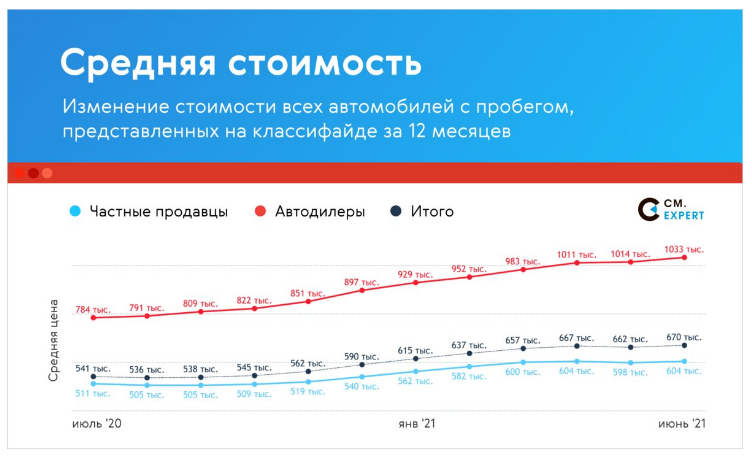

In [35]:
# Поправочный коэффициент
coef = (100 - (670-545)*100/545)/100
coef

0.7706422018348624

In [37]:
X_sub = test_data.drop(['price'], axis=1)

# нормализуем числовые значения
StandardScaler().fit_transform(X_sub[num_cols].values)

array([[-0.93386586, -0.87419591,  0.79900791,  0.78116749,  0.67192021,
         0.9729518 ],
       [-0.87774016, -1.00766485,  1.33839772,  0.78116749,  1.09759949,
        -1.42152856],
       [-0.4062843 , -0.73513472,  0.79900791,  0.78116749,  0.67192021,
        -1.42152856],
       ...,
       [-0.20423178,  1.96662547, -1.62824627, -0.6412471 , -1.74026238,
         0.9729518 ],
       [-0.04707983, -0.71030237,  0.66416045,  0.78116749,  0.53002712,
        -0.22428838],
       [ 0.5254023 ,  0.77467244, -0.14492428,  0.78116749, -0.17943835,
         0.9729518 ]])

In [38]:
kitty = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
kitty.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

predict_submission = (np.exp(kitty.predict(X_sub)))*coef

In [39]:
sample_submission = pd.read_csv('sample_submission.csv')

sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_prediction.csv', index=False)
sample_submission.head(10)

sell_id         price
0  1100575026  5.813521e+05
1  1100549428  8.079538e+05
2  1100658222  8.085362e+05
3  1100937408  6.483671e+05
4  1101037972  6.316606e+05
5  1100912634  6.277128e+05
6  1101228730  5.899366e+05
7  1100165896  3.838976e+05
8  1100768262  1.708238e+06
9  1101218501  6.998317e+05

MAPE = 17.38885 на kaggle LB . Не отлично но хорошо. 

## Выводы

По итогам работы над проектом получили модель предсказывающую цену автомобиля, что позволяет тщательней присмотреться к автомобилям с подозрительно низкой или неоправдано высокой ценой. Модель желательно использовать на свежих данных т.к. инфляция сильно влияет на качество предсказания.

Результаты работы в виде файла submission_prediction.csv размещены на площадке Kaggle. Метрика MAPE равена 17,38885 что довольно сильно отличается от результата показанного на тренировочной выборке. Самая вероятная причина в повышении цен на авто и сложности учета данного обстоятельства.

Для меня эта работа была полезна следующим:
1. Впервые попробовал парсить сайт, интересный опыт!
2. Еще раз попрактиковался делать EDA и генерировать новые признаки.
3. Впервые попробовал применить CatBoost.

Что так и не сделал:
1. Не пробовал поработать в команде
2. C EDA можно было поработать побольше. Например оценить важность каких-либо признаков или убрать признаки которые коррелировали друг с другом.
3. Из-за отсутствия времени не попробовал стекинг. Можно было скрестить например CatBoost и DecisionTreeClassifier. Позже обязательно попробую сделать это.